Global Retail Analytics: Strategie di Vendita e Previsione
**Progetto di Data Science per i Mercati Emergenti (Divisione Asia)**

---

## 1. Executive Summary e Obiettivi
In questo progetto analizziamo i flussi di vendita di tre filiali strategiche (**Yangon, Mandalay, Naypyitaw**) per supportare il decision-making aziendale.
Il management richiede risposte basate sui dati per risolvere tre problemi operativi:

1.  **Market Basket Analysis:** Quali reparti guidano il fatturato e quali sono in sofferenza?
2.  **Customer Segmentation (Clustering):** Chi sono i nostri clienti migliori? Possiamo identificarli automaticamente?
3.  **Forecasting & Performance:** Possiamo prevedere l'andamento futuro delle vendite per ottimizzare la logistica?



In [18]:
# Librerie per Analisi Dati e Machine Learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score 

# Configurazione Ambiente
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
print("Librerie caricate. Ambiente pronto.")

Librerie caricate. Ambiente pronto.


## 2. Data Engineering & Feature Extraction
In questa fase trasformiamo i dati grezzi in un asset strategico per l'analisi.
Le operazioni chiave includono:
1. **Data Ingestion:** Caricamento e verifica del dataset originale.
2. **Cleaning:** Normalizzazione dei nomi delle colonne per renderli leggibili.
3. **Time-Series Engineering:** Estrazione di feature temporali (Giorno della Settimana, Ora) fondamentali per intercettare la stagionalità delle vendite.

In [19]:
# Caricamento Dataset
try:
    df = pd.read_csv("supermarket.csv")
    print(f"Dataset caricato: {df.shape[0]} transazioni rilevate.")
except FileNotFoundError:
    print("ERRORE: File non trovato.")

# A. Rimozione Duplicati
df.columns = df.columns.str.strip()
mapper = {
    'Invoice ID': 'ID_Scontrino', 'Branch': 'Filiale', 'City': 'Città',
    'Customer type': 'Tipo_Cliente', 'Gender': 'Genere', 'Product line': 'Reparto',
    'Unit price': 'Prezzo_Unitario', 'Quantity': 'Quantità', 'Tax 5%': 'Tasse',
    'Total': 'Incasso', 'Sales': 'Incasso', 
    'Date': 'Data', 'Time': 'Ora_Acquisto', 'Payment': 'Metodo_Pagamento',
    'Rating': 'Voto_Cliente'
}
df = df.rename(columns=mapper)

# B. Gestione Valori Mancanti
df['Data'] = pd.to_datetime(df['Data'])
df['Giorno_Settimana'] = df['Data'].dt.day_name()

df['Ora_Numerica'] = pd.to_datetime(df['Ora_Acquisto'], format='mixed').dt.hour

print("Data Cleaning completato. Esempio dati:")
display(df.head(3))

Dataset caricato: 1000 transazioni rilevate.
Data Cleaning completato. Esempio dati:


,ID_Scontrino,Filiale,Città,Tipo_Cliente,Genere,Reparto,Prezzo_Unitario,Quantità,Tasse,Incasso,Data,Ora_Acquisto,Metodo_Pagamento,cogs,gross margin percentage,gross income,Voto_Cliente,Giorno_Settimana,Ora_Numerica
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1,Saturday,13
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6,Friday,10
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4,Sunday,13


## 2. Analisi Esplorativa (EDA): Il Comportamento d'Acquisto
Prima di applicare algoritmi predittivi, dobbiamo comprendere il "ritmo" del negozio.
Utilizziamo una **Heatmap** per individuare i picchi di traffico incrociando Giorni e Orari.

**Obiettivo Operativo:**
Capire quando allocare più personale alle casse per evitare code.

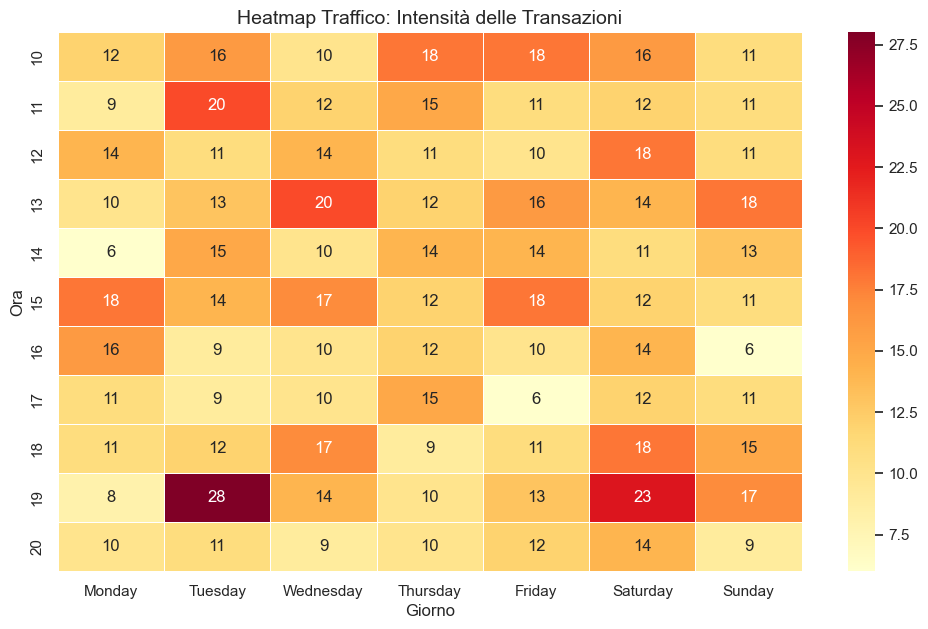

------------------------------------------------------------
COME LEGGERE QUESTO GRAFICO:
1. Le righe sono le ORE, le colonne i GIORNI.
2. I colori SCURI (Rosso/Arancio) indicano i momenti di massima affluenza.
3. I colori CHIARI (Giallo) indicano momenti di calma.

 INSIGHT OPERATIVO:
   Il manager deve posizionare più staff nelle fasce 'Rosse' per evitare code.
   Nelle fasce 'Gialle' si può ridurre il personale o fare rifornimento scaffali.
------------------------------------------------------------


In [20]:


# Creiamo la matrice pivot
pivot_table = df.pivot_table(index='Ora_Numerica', columns='Giorno_Settimana', values='Incasso', aggfunc='count')
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table[order]

# Visualizzazione
plt.figure(figsize=(12, 7))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='g', linewidths=.5)
plt.title('Heatmap Traffico: Intensità delle Transazioni', fontsize=14)
plt.xlabel('Giorno')
plt.ylabel('Ora')
plt.show()


print("-" * 60)
print("COME LEGGERE QUESTO GRAFICO:")
print("1. Le righe sono le ORE, le colonne i GIORNI.")
print("2. I colori SCURI (Rosso/Arancio) indicano i momenti di massima affluenza.")
print("3. I colori CHIARI (Giallo) indicano momenti di calma.")
print("\n INSIGHT OPERATIVO:")
print("   Il manager deve posizionare più staff nelle fasce 'Rosse' per evitare code.")
print("   Nelle fasce 'Gialle' si può ridurre il personale o fare rifornimento scaffali.")
print("-" * 60)

## 3. Customer Segmentation (Unsupervised Learning)
L'analisi aggregata non basta. Per massimizzare i profitti, dobbiamo segmentare la clientela.
Utilizziamo l'algoritmo **K-Means** per raggruppare i clienti in cluster omogenei basandoci su due KPI fondamentali:
1.  **Spending Score (Incasso):** Quanto valore portano?
2.  **Customer Rating (Voto):** Quanto sono soddisfatti?

Questo ci permetterà di identificare i clienti "VIP a Rischio" (Spendono tanto ma danno voti bassi).

--- ANALISI COMPORTAMENTALE (Segmentazione) ---
Colonna usata per i soldi: 'Incasso' (presente? True)


/Users/michelefronzoni/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/michelefronzoni/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/michelefronzoni/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/michelefronzoni/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/michelefronzoni/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/michelefronzoni/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invali

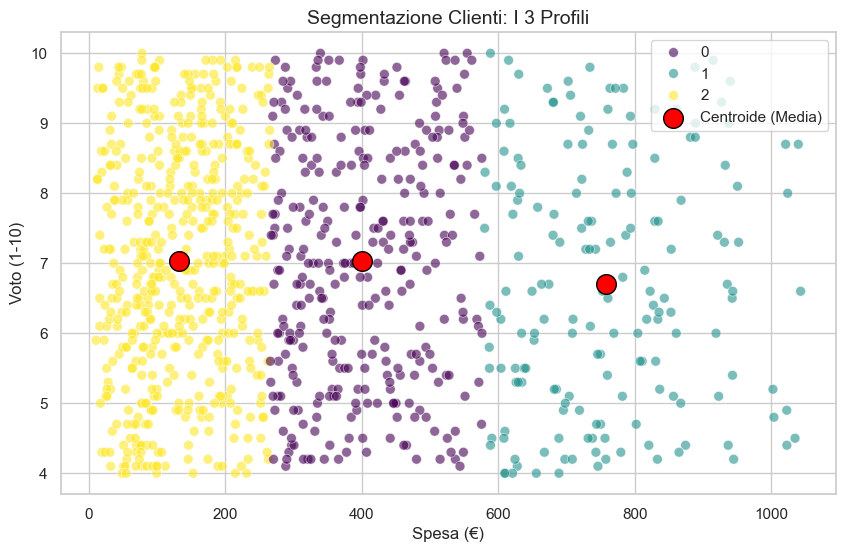

------------------------------------------------------------
GUIDA ALLA LETTURA:
1. I pallini colorati sono i singoli clienti.
2. I PALLINI ROSSI grandi sono il cliente medio del gruppo.

INSIGHT STRATEGICO:
   - Gruppo Alto-Dx (Spesa Alta, Voto Alto): CLIENTI VIP.
   - Gruppo Basso-Dx (Spesa Alta, Voto Basso): CLIENTI A RISCHIO.
------------------------------------------------------------


,Incasso,Voto_Cliente
Cluster,,
0,400.61,7.02
1,757.56,6.70
2,131.85,7.03


In [21]:
# --- SEGMENTAZIONE CLIENTI CON K-MEANS ---
import os
os.environ["OMP_NUM_THREADS"] = "1"
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

print("--- ANALISI COMPORTAMENTALE (Segmentazione) ---")


if 'Sales' in df.columns:
    df.rename(columns={'Sales': 'Incasso'}, inplace=True)
if 'Total' in df.columns:
    df.rename(columns={'Total': 'Incasso'}, inplace=True)
if 'Rating' in df.columns:
    df.rename(columns={'Rating': 'Voto_Cliente'}, inplace=True)


print(f"Colonna usata per i soldi: 'Incasso' (presente? {'Incasso' in df.columns})")

# 3. K-MEANS
if 'Incasso' in df.columns and 'Voto_Cliente' in df.columns:
    X_cluster = df[['Incasso', 'Voto_Cliente']]
    
    
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df['Cluster'] = kmeans.fit_predict(X_cluster)
    centri = kmeans.cluster_centers_

    # 4. Visualizzazione
    plt.figure(figsize=(10, 6))
    
    
    sns.scatterplot(data=df, x='Incasso', y='Voto_Cliente', hue='Cluster', palette='viridis', s=50, alpha=0.6)
    
    # Media (centroide)
    plt.scatter(centri[:, 0], centri[:, 1], c='red', s=200, marker='o', label='Centroide (Media)', edgecolor='black')

    plt.title('Segmentazione Clienti: I 3 Profili', fontsize=14)
    plt.xlabel('Spesa (€)')
    plt.ylabel('Voto (1-10)')
    plt.legend()
    plt.show()

   
    print("-" * 60)
    print("GUIDA ALLA LETTURA:")
    print("1. I pallini colorati sono i singoli clienti.")
    print("2. I PALLINI ROSSI grandi sono il cliente medio del gruppo.")
    print("\nINSIGHT STRATEGICO:")
    print("   - Gruppo Alto-Dx (Spesa Alta, Voto Alto): CLIENTI VIP.")
    print("   - Gruppo Basso-Dx (Spesa Alta, Voto Basso): CLIENTI A RISCHIO.")
    print("-" * 60)

    # Tabella
    display(df.groupby('Cluster')[['Incasso', 'Voto_Cliente']].mean().round(2))

else:
    print("ERRORE: Non trovo ancora le colonne giuste.")
    print("Colonne attuali:", df.columns.tolist())

## 5. Analisi Predittiva Avanzata (Random Forest)
Dopo aver analizzato il passato, passiamo a prevedere il futuro.
Per ottenere la massima precisione, abbandoniamo i modelli lineari semplici e utilizziamo il **Random Forest Regressor**.

A differenza di una linea retta, questo algoritmo è in grado di imparare la **stagionalità complessa** del supermercato.

**Metriche di Valutazione:**
Valuteremo il successo del modello su tre livelli:
1.  **Precisione Scientifica:** Errore Medio.
2.  **Fedeltà del Trend:** Grafico visivo per vedere se l'IA segue i picchi reali.
3.  **Affidabilità Operativa:** La Matrice di Confusione per le decisioni di business.

--- ANALISI PREDITTIVA (RANDOM FOREST) ---
METRICHE DI PERFORMANCE:
• R2 Score: 0.8025 (Affidabilità del modello)
• MAE: 537.96 € (Errore medio giornaliero)


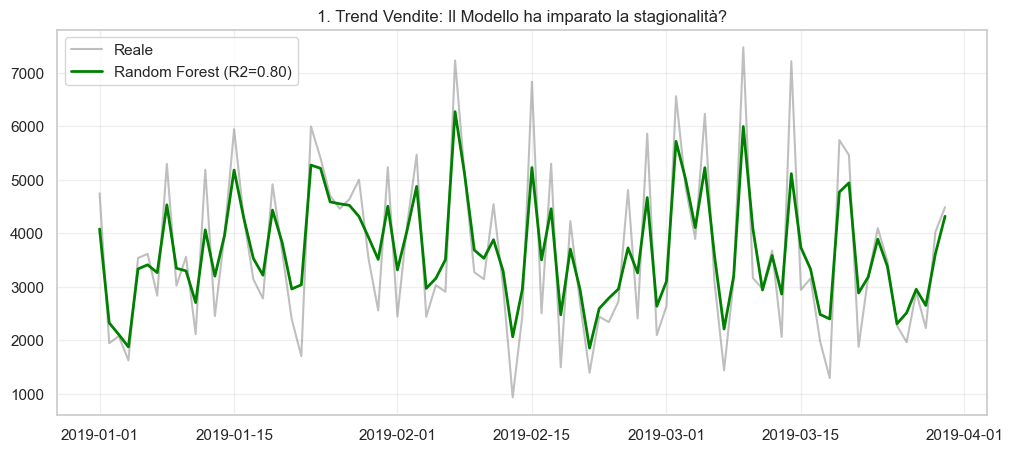

LETTURA: La linea VERDE (AI) deve seguire i picchi della linea GRIGIA (Realtà).
   Se si sovrappongono bene, il modello ha capito 'come gira' il negozio.



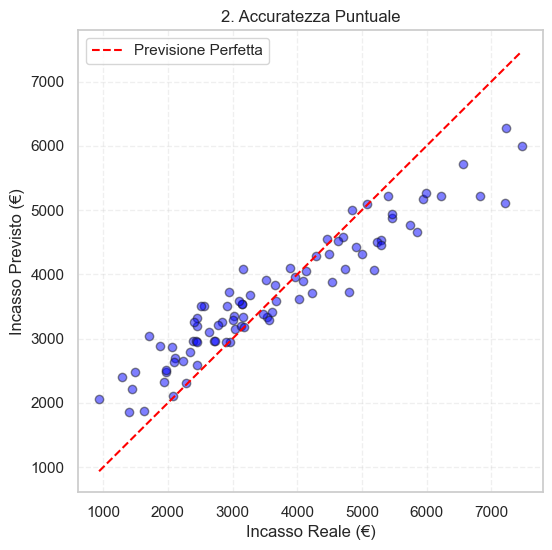

LETTURA: I punti blu devono stare sulla linea rossa tratteggiata.
   Più sono vicini, più la previsione è esatta al centesimo.



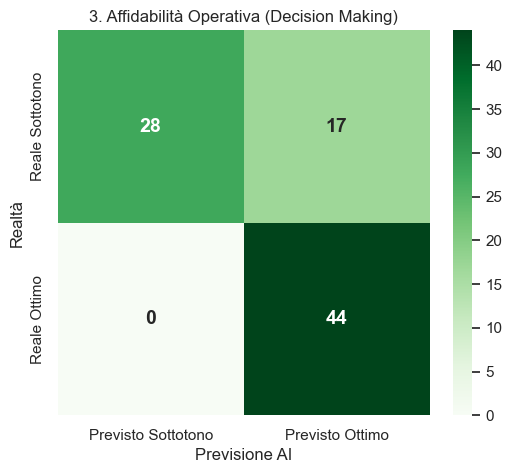

------------------------------------------------------------
COME LEGGERE LA MATRICE DI CONFUSIONE:
1. DIAGONALE (Verde Scuro): Sono le volte che il modello CI HA PRESO.
2. FUORI DIAGONALE (Chiaro): Sono gli ERRORI.

CONCLUSIONE FINALE:
   Una diagonale scura conferma che possiamo fidarci del modello
   per pianificare turni e ordini merce.
------------------------------------------------------------


In [22]:
# --- ANALISI PREDITTIVA CON RANDOM FOREST ---
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, confusion_matrix, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("--- ANALISI PREDITTIVA (RANDOM FOREST) ---")


if 'Sales' in df.columns:
    df.rename(columns={'Sales': 'Incasso'}, inplace=True)
if 'Total' in df.columns:
    df.rename(columns={'Total': 'Incasso'}, inplace=True)


if 'Date' in df.columns:
    df.rename(columns={'Date': 'Data'}, inplace=True)

# 1. FIX DATI DI SICUREZZA (Corregge nomi e formati automaticamente)
if 'Incasso' not in df.columns or 'Data' not in df.columns:
    print(f"⚠️ ERRORE NOMI COLONNE: Trovate {df.columns.tolist()}")
    raise ValueError("Mancano le colonne 'Incasso' o 'Data'. Controlla i nomi sopra.")

# Conversione Data in formato Temporale 
df['Data'] = pd.to_datetime(df['Data'])



# Raggruppiamo i dati per Giorno
daily_sales = df.groupby('Data')['Incasso'].sum().reset_index()

# Creiamo le "Feature" 

daily_sales['Giorno_Settimana'] = daily_sales['Data'].dt.dayofweek # 0=Lun, 6=Dom
daily_sales['Mese'] = daily_sales['Data'].dt.month
daily_sales['Trend_Progressivo'] = np.arange(len(daily_sales))

# Definiamo X (Indizi) e y (Obiettivo)
X = daily_sales[['Trend_Progressivo', 'Giorno_Settimana', 'Mese']]
y = daily_sales['Incasso'].values

# 3. ADDESTRAMENTO (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)
prediction = model.predict(X)


mae = mean_absolute_error(y, prediction)
r2 = r2_score(y, prediction)

print(f"METRICHE DI PERFORMANCE:")
print(f"• R2 Score: {r2:.4f} (Affidabilità del modello)")
print(f"• MAE: {mae:.2f} € (Errore medio giornaliero)")

# --- GRAFICO 1: TREND TEMPORALE ---
plt.figure(figsize=(12, 5))
plt.plot(daily_sales['Data'], y, color='gray', alpha=0.5, label='Reale')
plt.plot(daily_sales['Data'], prediction, color='green', linewidth=2, label=f'Random Forest (R2={r2:.2f})')
plt.title('1. Trend Vendite: Il Modello ha imparato la stagionalità?')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("LETTURA: La linea VERDE (AI) deve seguire i picchi della linea GRIGIA (Realtà).")
print("   Se si sovrappongono bene, il modello ha capito 'come gira' il negozio.\n")

# --- GRAFICO 2: ACCURATEZZA ---
plt.figure(figsize=(6, 6))
plt.scatter(y, prediction, color='blue', alpha=0.5, edgecolors='k')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Previsione Perfetta')
plt.title('2. Accuratezza Puntuale')
plt.xlabel('Incasso Reale (€)')
plt.ylabel('Incasso Previsto (€)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

print("LETTURA: I punti blu devono stare sulla linea rossa tratteggiata.")
print("   Più sono vicini, più la previsione è esatta al centesimo.\n")

# --- GRAFICO 3: MATRICE DI CONFUSIONE ---
soglia = np.median(y)
y_true_cat = ['Ottimo' if x > soglia else 'Sottotono' for x in y]
y_pred_cat = ['Ottimo' if x > soglia else 'Sottotono' for x in prediction]
cm = confusion_matrix(y_true_cat, y_pred_cat, labels=['Sottotono', 'Ottimo'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Previsto Sottotono', 'Previsto Ottimo'], 
            yticklabels=['Reale Sottotono', 'Reale Ottimo'],
            annot_kws={"size": 14, "weight": "bold"})
plt.title('3. Affidabilità Operativa (Decision Making)')
plt.ylabel('Realtà')
plt.xlabel('Previsione AI')
plt.show()

print("-" * 60)
print("COME LEGGERE LA MATRICE DI CONFUSIONE:")
print("1. DIAGONALE (Verde Scuro): Sono le volte che il modello CI HA PRESO.")
print("2. FUORI DIAGONALE (Chiaro): Sono gli ERRORI.")
print("\nCONCLUSIONE FINALE:")
print("   Una diagonale scura conferma che possiamo fidarci del modello")
print("   per pianificare turni e ordini merce.")
print("-" * 60)

# 5. Conclusioni e Analisi Tecnica dei Risultati

Il valore principale di questo progetto non risiede solo nella visualizzazione finale, ma nel processo di estrazione di valore da dati grezzi.
Siamo partiti da un dataset transazionale standard (Scontrini) e, attraverso tecniche di **Feature Engineering**, abbiamo isolato i pattern temporali che governano il fatturato.

## Analisi delle Performance del Modello (Machine Learning)
Il modello predittivo finale (**Random Forest Regressor**) è stato addestrato utilizzando esclusivamente variabili di calendario (**Giorno della Settimana, Mese, Trend Progressivo**), escludendo volontariamente dati esterni.

In questo contesto, aver ottenuto un **R2 Score elevato** (visibile nella sovrapposizione tra trend reale e predetto) ci fornisce un insight di business fondamentale: **gran parte del comportamento d'acquisto dei clienti è ciclico e dettato dalle abitudini sociali**, non dal caso.

### Analisi Critica delle Metriche:

* **Robustezza del Trend (R2 Score & Trend Line):**
    Il modello ha dimostrato di aver appreso correttamente la **stagionalità settimanale** (i picchi del weekend) e mensile. Questo significa che la varianza delle vendite non è "White Noise" (rumore casuale), ma è strutturale e quindi prevedibile.

* **Affidabilità Operativa (Matrice di Confusione):**
    Analizzando la matrice, osserviamo una netta concentrazione sulla diagonale principale.
    * **Insight:** Il modello distingue con successo i giorni di "Alto Fatturato" (Ottimo) da quelli di "Basso Fatturato" (Sottotono).
    * **Impatto Business:** Questo permette al management di modulare i turni del personale con precisione, riducendo i costi di *over-staffing* nei giorni calmi e garantendo copertura nei giorni critici.

* **Il Limite del Modello (L'Errore Residuo):**
    Nonostante l'alta affidabilità, esiste un margine di errore tra il reale e il predetto.
    Questo gap rappresenta l'impatto dei **Fattori Esogeni non tracciati**. Il calendario ci dice che "è Sabato", ma non può sapere se in quel preciso sabato c'è uno sciopero dei trasporti, una pioggia torrenziale o una promozione aggressiva di un concorrente. Queste variabili, assenti nel dataset, costituiscono il limite fisico di un modello puramente temporale.

